# Forecasting of air pollution
dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

## Data import

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, LSTM
import urllib.request

In [9]:
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
response = urllib.request.urlretrieve(URL, "air_pollution.csv")

In [27]:
dataframe = pd.read_csv('air_pollution.csv')
dataframe.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [28]:
from datetime import datetime

def parse(x):
 return datetime.strptime(x, '%Y %m %d %H')

In [29]:
dataframe = pd.read_csv('air_pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataframe = dataframe.drop('No', axis=1)
dataframe.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [30]:
dataframe['pm2.5'].fillna(0, inplace=True)
dataframe.columns = ['pollution', 'dew', 'temp', 'pres', 'cbwd', 'lws', 'ls', 'lr']
dataframe.index.name = 'time'
dataframe.head()

,pollution,dew,temp,pres,cbwd,lws,ls,lr
time,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0


In [31]:
dataframe = dataframe[24:]
dataframe.head()

,pollution,dew,temp,pres,cbwd,lws,ls,lr
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<Figure size 432x288 with 0 Axes>

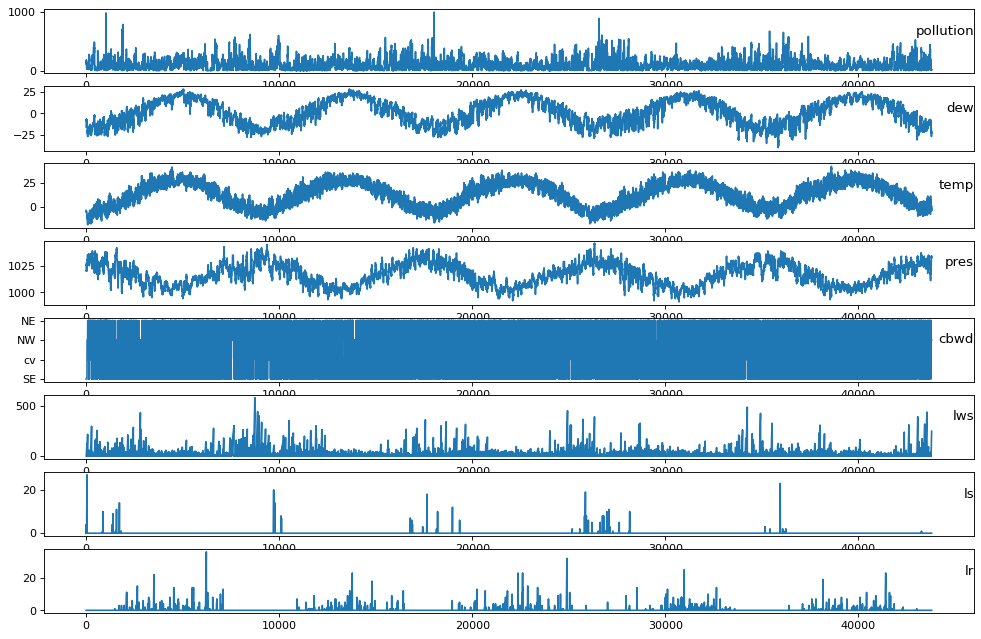

In [32]:
n_axes = dataframe.shape[1]
plt.figure()
plt.figure(figsize=(15, 10), dpi=80)
for i in range(n_axes):
    plt.subplot(n_axes, 1, i+1)
    plt.plot(dataframe.values[:, i])
    plt.title(dataframe.columns[i], y=0.5, loc='right')

# Data preprocessing

In [33]:
def series_to_dataset(data, n_in=1, n_out=1, dropnan=True):
    if type(data) is list:
        n_features = 1 
    else:
        n_features = data.shape[1]
    dataframe = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_features)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_features)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_features)]
    # put it all together
    dataset = pd.concat(cols, axis=1)
    dataset.columns = names
    # drop rows with NaN values
    if dropnan:
        dataset.dropna(inplace=True)
    return dataset

In [34]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

values = dataframe.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

dataset = series_to_dataset(scaled_values, n_in=1, n_out=1)

dataset.drop(dataset.columns[range(9, 16)], axis=1, inplace=True)
dataset.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [35]:
values = dataset.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

## Model

In [19]:
model = Sequential([
    LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

Epoch 1/50
122/122 - 3s - loss: 0.0605 - val_loss: 0.0527 - 3s/epoch - 25ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0443 - val_loss: 0.0526 - 893ms/epoch - 7ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0285 - val_loss: 0.0439 - 871ms/epoch - 7ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0187 - val_loss: 0.0389 - 892ms/epoch - 7ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0167 - val_loss: 0.0281 - 876ms/epoch - 7ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0155 - val_loss: 0.0204 - 884ms/epoch - 7ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0178 - 999ms/epoch - 8ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0167 - 908ms/epoch - 7ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0157 - 864ms/epoch - 7ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0151 - 939ms/epoch - 8ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0147 - 890ms/epoch - 7ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0144 - 846ms/epoch - 7ms/step
Epo

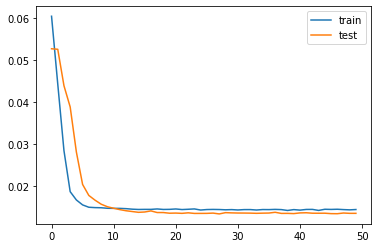

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluation

In [21]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_predictions = np.concatenate((predictions, test_X[:, 1:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.463


## Multiple steps lag

In [51]:
values = dataframe.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

n_hours = 3
n_features = 8

dataset = series_to_dataset(scaled_values, n_hours, 1)
dataset.shape

(43797, 32)

In [52]:
values = dataset.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
train_X.shape, train_y.shape

((8760, 24), (8760,))

In [53]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 3, 8), (8760,), (35037, 3, 8), (35037,))

In [54]:
model = Sequential([
    LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

Epoch 1/50
122/122 - 3s - loss: 0.0544 - val_loss: 0.0372 - 3s/epoch - 28ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0259 - val_loss: 0.0221 - 1s/epoch - 10ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0212 - val_loss: 0.0200 - 1s/epoch - 10ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0204 - val_loss: 0.0201 - 1s/epoch - 10ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0200 - val_loss: 0.0197 - 1s/epoch - 10ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0201 - val_loss: 0.0187 - 1s/epoch - 10ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0198 - val_loss: 0.0187 - 1s/epoch - 9ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0191 - val_loss: 0.0183 - 1s/epoch - 11ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0186 - val_loss: 0.0180 - 1s/epoch - 11ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0182 - val_loss: 0.0177 - 1s/epoch - 9ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0177 - val_loss: 0.0176 - 1s/epoch - 10ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0174 - val_loss: 0.0172 - 1s/epoch - 10ms/step
Epoch 13/50
122/122 - 1s - 

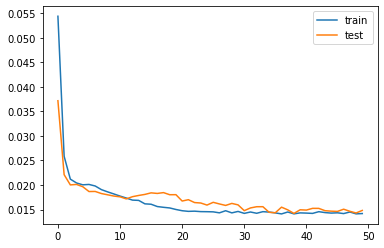

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [56]:
predictions = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

inv_predictions = np.concatenate((predictions, test_X[:, -7:]), axis=1)
inv_predictions = scaler.inverse_transform(inv_predictions)
inv_predictions = inv_predictions[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_predictions))

In [57]:
rmse

26.998125